#### This notebook demonstrates the use of adversarial debiasing algorithm to learn a fair classifier.
Adversarial debiasing [1] is an in-processing technique that learns a classifier to maximize prediction accuracy and simultaneously reduce an adversary's ability to determine the protected attribute from the predictions. This approach leads to a fair classifier as the predictions cannot carry any group discrimination information that the adversary can exploit. We will see how to use this algorithm for learning models with and without fairness constraints and apply them on the Adult dataset.

In [1]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_compas, load_preproc_data_german

from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

import tensorflow as tf

C:\Users\anush\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\anush\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\anush\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\anush\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

#### Load dataset and set options

In [2]:
# Get the dataset and split into train and test
dataset_orig = load_preproc_data_german()

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

In [3]:
# print(type(dataset_orig_train))

In [4]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(700, 11)


#### Favorable and unfavorable labels

1.0 2.0


#### Protected attribute names

['sex', 'age']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed']


#### Metric for original training data

In [5]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.058036
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.115084


In [6]:
min_max_scaler = MaxAbsScaler()
dataset_orig_train.features = min_max_scaler.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = min_max_scaler.transform(dataset_orig_test.features)
metric_scaled_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())


#### Scaled dataset - Verify that the scaling does not affect the group label statistics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.058036
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.115084


### Learn plan classifier without debiasing

In [7]:
# Load post-processing algorithm that equalizes the odds
# Learn parameters with debias set to False
sess = tf.Session()
plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess)

In [8]:
plain_model.fit(dataset_orig_train)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




epoch 0; iter: 0; batch classifier loss: 0.769426
epoch 1; iter: 0; batch classifier loss: 0.666714
epoch 2; iter: 0; batch classifier loss: 0.634194
epoch 3; iter: 0; batch classifier loss: 0.624004
epoch 4; iter: 0; batch classifier loss: 0.608571
epoch 5; iter: 0; batch classifier loss: 0.611630
epoch 6; iter: 0; batch classifier loss: 0.576460
epoch 7; iter: 0; batch classifier loss: 0.630478
epoch 8; iter: 0; ba

In [9]:
# plain_model.fit(dataset_orig_train)

In [10]:
# Apply the plain model to test data
dataset_nodebiasing_train = plain_model.predict(dataset_orig_train)
dataset_nodebiasing_test = plain_model.predict(dataset_orig_test)

In [11]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
metric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(dataset_nodebiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())

metric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(dataset_nodebiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

display(Markdown("#### Plain model - without debiasing - classification metrics"))
classified_metric_nodebiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_nodebiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.120536
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.113780


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.713333
Test set: Balanced classification accuracy = 0.539744
Test set: Disparate impact = 0.881802
Test set: Equal opportunity difference = -0.036338
Test set: Average odds difference = -0.140612
Test set: Theil_index = 0.089014


### Apply in-processing algorithm based on adversarial learning

In [12]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()

In [13]:
# Learn parameters with debias set to True
debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)

In [14]:
debiased_model.fit(dataset_orig_train)

epoch 0; iter: 0; batch classifier loss: 0.656567; batch adversarial loss: 0.709344
epoch 1; iter: 0; batch classifier loss: 0.641594; batch adversarial loss: 0.727363
epoch 2; iter: 0; batch classifier loss: 0.616978; batch adversarial loss: 0.714867
epoch 3; iter: 0; batch classifier loss: 0.609541; batch adversarial loss: 0.710521
epoch 4; iter: 0; batch classifier loss: 0.617248; batch adversarial loss: 0.711693
epoch 5; iter: 0; batch classifier loss: 0.639821; batch adversarial loss: 0.742497
epoch 6; iter: 0; batch classifier loss: 0.613757; batch adversarial loss: 0.710913
epoch 7; iter: 0; batch classifier loss: 0.552588; batch adversarial loss: 0.700107
epoch 8; iter: 0; batch classifier loss: 0.583764; batch adversarial loss: 0.717890
epoch 9; iter: 0; batch classifier loss: 0.577260; batch adversarial loss: 0.687692
epoch 10; iter: 0; batch classifier loss: 0.564012; batch adversarial loss: 0.714105
epoch 11; iter: 0; batch classifier loss: 0.565985; batch adversarial loss:

In [15]:
# Apply the plain model to test data
dataset_debiasing_train = debiased_model.predict(dataset_orig_train)
dataset_debiasing_test = debiased_model.predict(dataset_orig_test)

In [16]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(dataset_debiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())



display(Markdown("#### Plain model - without debiasing - classification metrics"))
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())



display(Markdown("#### Model - with debiasing - classification metrics"))
classified_metric_debiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.120536
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.113780


#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.063813
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.039013


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.713333
Test set: Balanced classification accuracy = 0.539744
Test set: Disparate impact = 0.881802
Test set: Equal opportunity difference = -0.036338
Test set: Average odds difference = -0.140612
Test set: Theil_index = 0.089014


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.693333
Test set: Balanced classification accuracy = 0.542658
Test set: Disparate impact = 0.956059
Test set: Equal opportunity difference = 0.032844
Test set: Average odds difference = -0.060567
Test set: Theil_index = 0.127069



    References:
    [1] B. H. Zhang, B. Lemoine, and M. Mitchell, "Mitigating UnwantedBiases with Adversarial Learning," 
    AAAI/ACM Conference on Artificial Intelligence, Ethics, and Society, 2018.

In [17]:
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
FPR = classified_metric_debiasing_test.false_positive_rate()

print(TPR)
print(TNR)
print(FPR)

0.9423076923076923
0.11956521739130435
0.8804347826086957


In [20]:
# def plot_metrics(metrics_before, metrics_after, 
#                  sensitive_attr='Sex',
#                  mitigation='Adversarial De-biasing', dataset='Loan'):
#     total = 4; cols = 4
#     rows = total //cols; rows += total % cols
#     pos = range(1, total+1)
    
#     fig = plt.figure(figsize=(36,rows*8))
#     x_pos = [1,2]
#     kwargs = {
#         'color': ['grey', 'teal'],
#         'tick_label': ['Before mitigation', 'After mitigation']
#     }
    
#     i = 0; subplot_pad=20
#     ax = fig.add_subplot(rows, cols, pos[i])
#     ax.set_title('Classification Accuracy Difference', pad=subplot_pad)
#     ax.bar(x_pos, [metrics_before.accuracy(), metrics_after.accuracy()],
#                   **kwargs)

#     metrics = {'Demographic Parity Difference': 'mean_difference',
#                'Disparate Impact': 'disparate_impact',
#                'Equal Opportunity Difference': 'equal_opportunity_difference'}
    
#     for title, methodname in  metrics.items():
#         i += 1;
#         ax = fig.add_subplot(rows, cols, pos[i])
#         ax.set_title(title, pad=subplot_pad)
#         ax.set_ylim([-0.5,1])
#         ax.bar(x_pos, 
#                      [getattr(metrics_before, methodname)(), getattr(metrics_after, methodname)()],
#                      **kwargs)
        
#     fig.subplots_adjust(bottom=0.2)
#     title = 'Impact of {} on {} dataset - {}'.format(mitigation, dataset, sensitive_attr)
#     fig.suptitle(title, y=0.08)
#     fig.savefig('C:/Users/anush/Downloads/ML/Project/graphs/'+title+'.png')
#     plt.show()

# font = {'font.size'   : 18,
#         'figure.titlesize': 30}
# plt.rcParams.update(font)

# plot_metrics(classified_metric_nodebiasing_test, classified_metric_debiasing_test)


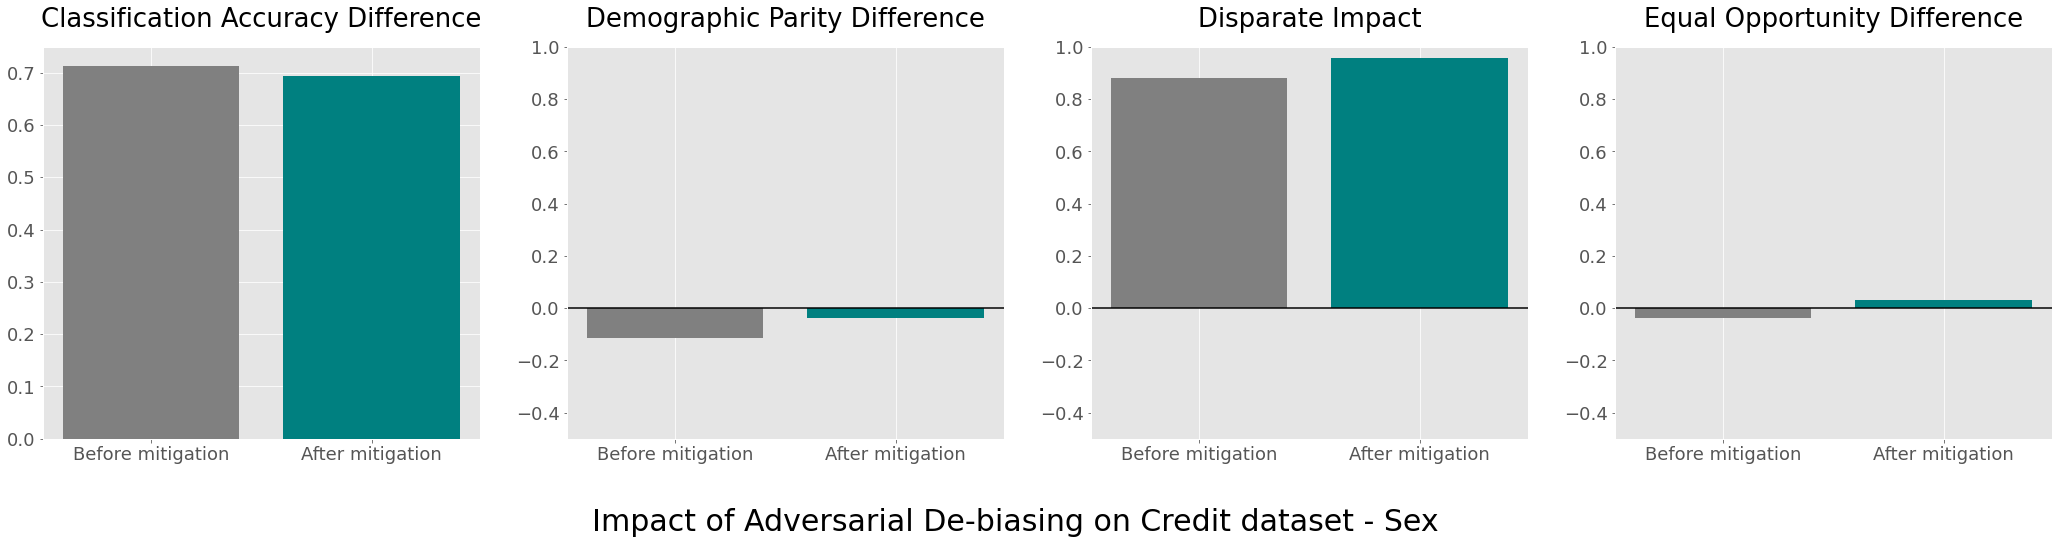

In [19]:
from common_utils import plot_metrics

plot_metrics(classified_metric_nodebiasing_test, classified_metric_debiasing_test, sensitive_attr='Sex', dataset='Credit')